In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import imagenet_utils
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *
from collections import Counter

import multiprocessing
from multiprocessing.dummy import Pool
from pprint import pprint

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

Using TensorFlow backend.
/home/ypw/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ypw/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
batch_size = 4 * n_gpus
model_name = ''
preprocess_func = inception_resnet_v2.preprocess_input
MODEL = InceptionResNetV2

f = 2
width = int(2560 / f)
height = int(1920 / f)
classes = ['正常', '吊经', '擦洞', '跳花', '毛洞', '织稀', '扎洞', '缺经', '毛斑', '其他']
n_classes = len(classes)

In [3]:
idg = ImageDataGenerator()
gen_test = idg.flow_from_directory('testb', target_size=(height, width), shuffle=False, 
                                   interpolation='lanczos', class_mode=None, batch_size=batch_size)

Found 647 images belonging to 1 classes.


# 按 val_auc 排序

In [4]:
a = [(x[x.rfind('-')+1:x.rfind('.')], x) for x in glob('models/*.h5')]
a = sorted(a, key=lambda x:x[0], reverse=True)[:50]
a

[('0.962335', 'models/irv2_0731-0.001001-120-0.962335.h5'),
 ('0.961481', 'models/irv2_0802_4e-5-0.001000-42-0.961481.h5'),
 ('0.959774', 'models/irv2_0802_4e-5-0.001000-46-0.959774.h5'),
 ('0.959667', 'models/irv2_0802_4e-5-0.000100-60-0.959667.h5'),
 ('0.957960', 'models/irv2_0802_4e-5-0.001000-48-0.957960.h5'),
 ('0.957960', 'models/irv2_0802_4e-5-0.001000-47-0.957960.h5'),
 ('0.956146', 'models/irv2_0802_4e-5-0.001000-45-0.956146.h5'),
 ('0.954866', 'models/irv2_0802-0.001000-30-0.954866.h5'),
 ('0.954225', 'models/irv2_0801-0.000100-60-0.954225.h5'),
 ('0.954012', 'models/irv2_0802_4e-5-0.000100-56-0.954012.h5'),
 ('0.953905', 'models/irv2_0802_4e-5-0.000100-51-0.953905.h5'),
 ('0.953478', 'models/irv2_0802_4e-5-0.001000-40-0.953478.h5'),
 ('0.953478', 'models/irv2_0802_4e-5-0.001000-50-0.953478.h5'),
 ('0.953158', 'models/irv2_0802_4e-5-0.000100-59-0.953158.h5'),
 ('0.952838', 'models/irv2_0802_4e-5-0.001000-35-0.952838.h5'),
 ('0.952251', 'models/irv2_0802_4e-5-0.001000-41-0.952

# 构建模型

In [5]:
base_model = MODEL(include_top=False, weights='imagenet')
input_tensor = Input((height, width, 3))
x = Lambda(preprocess_func)(input_tensor)
x = base_model(x)
x = GlobalAvgPool2D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_tensor, x)

In [6]:
model_parallel = multi_gpu_model(model, n_gpus)

# 预测结果

In [7]:
def predict(fname_model):
    model.load_weights(fname_model)
    y_pred = model_parallel.predict_generator(gen_test, verbose=1, workers=multiprocessing.cpu_count())
    
    y_pred2 = 1 - y_pred[:,0]
    
    plt.figure()
    plt.hist(y_pred2);
    
    # 直接 clip 法
    y_pred4 = np.round(y_pred2, 6).clip(1e-6, 1-1e-6)
    
    # 排序法
    table = np.linspace(0.1, 0.9, num=y_pred2.shape[0])
    index = np.argsort(y_pred2)
    y_pred3 = np.zeros(y_pred2.shape)
    y_pred3[index] = table
    
    fname_model2 = fname_model[fname_model.rfind('/')+1:]
    with open(f'outs/pred_{fname_model2}_3.csv', 'w') as f:
        f.write('filename,probability\n')
        for fname, value in zip(gen_test.filenames, y_pred3):
            fname = fname[fname.rfind('/')+1:]
            f.write(f'{fname},{value:.6f}\n')

    with open(f'outs/pred_{fname_model2}_4.csv', 'w') as f:
        f.write('filename,probability\n')
        for fname, value in zip(gen_test.filenames, y_pred4):
            fname = fname[fname.rfind('/')+1:]
            f.write(f'{fname},{value:.6f}\n')
    return y_pred

81/81 [==============================] - 49s 604ms/step


array([[8.9601243e-01, 2.8574364e-02, 2.9244139e-03, ..., 7.4108113e-03,
        3.7328920e-03, 3.0454723e-02],
       [5.8824583e-07, 3.0124176e-03, 1.2861930e-01, ..., 1.3223969e-03,
        5.3248379e-02, 3.8347533e-01],
       [8.2202695e-02, 1.4217223e-01, 2.1868411e-02, ..., 1.7597163e-02,
        7.8879915e-02, 4.0076387e-01],
       ...,
       [3.4445858e-07, 1.9955386e-03, 4.8683450e-01, ..., 6.6808966e-04,
        5.6304093e-02, 4.7513922e-03],
       [9.8057681e-01, 3.3515212e-03, 8.7719579e-04, ..., 6.9539034e-04,
        9.9526322e-04, 5.9090848e-03],
       [6.3133058e-07, 8.8677643e-04, 6.4077574e-01, ..., 3.8140724e-04,
        3.9491050e-02, 3.0756162e-03]], dtype=float32)

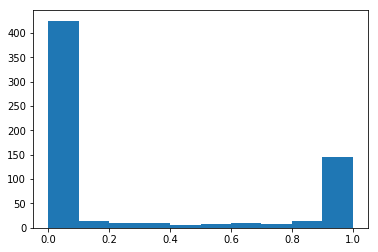

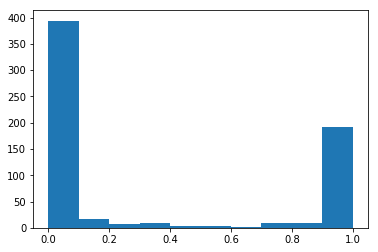

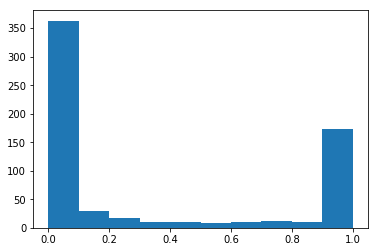

In [8]:
predict('models/irv2_0731-0.001001-120-0.962335.h5')
predict('models/irv2_0802_4e-5-0.000100-60-0.959667.h5')
predict('models/irv2_0802-0.001000-30-0.954866.h5')